In [ ]:
import torch
torch.cuda.empty_cache()

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp

def checkpoint_sequential(module, x):
    return cp.checkpoint(module, x)

class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        def double_conv(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(
                    in_channels,
                    out_channels,
                    kernel_size=3,
                    padding=1,
                    bias=False
                ),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels,
                          out_channels,
                          kernel_size=3,
                          padding=1,
                          bias=False
                ),
                nn.ReLU(inplace=True)
            )

        def Ct(input_channels, output_channels):
          return nn.ConvTranspose2d(
              input_channels,
              output_channels,
              kernel_size=2,
              stride=2
          )

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        self.conv1 = double_conv(3, 64)
        # self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = double_conv(64, 128)
        # self.pool2 = nn.MaxPool2d(2)

        self.conv3 = double_conv(128, 256)
        # self.pool3 = nn.MaxPool2d(2)

        self.conv4 = double_conv(256, 512)
        # self.pool4 = nn.MaxPool2d(2)

        # Bottleneck
        self.conv5 = double_conv(512, 1024)


        # Decoder
        self.up6 = Ct(1024, 512)
        self.conv6 = double_conv(1024, 512)

        self.up7 = Ct(512, 256)
        self.conv7 = double_conv(512, 256)

        self.up8 = Ct(256, 128)
        self.conv8 = double_conv(256, 128)

        self.up9 = Ct(128, 64)
        self.conv9 = double_conv(128, 64)

        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def crop_image(self, tensor, target_tensor):
        target_size = target_tensor.size()[2]
        tensor_size = tensor.size()[2]
        delta = tensor_size - target_size
        delta = delta // 2
        return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]

    def forward(self, image):
        # Store original size
        # original_size = x.size()[2:]

        # Encoder
        c1 = self.conv1(image)
        # c1 = checkppoint_sequential(self.conv1, p1)
        p1 = self.pool(c1)

        c2 = self.conv2(p1)
        # c2 = checkpoint_sequential(self.conv2, p1)
        p2 = self.pool(c2)

        c3 = self.conv3(p2) # Corrected from self.conv2 to self.conv3
        # c3 = checkpoint_sequential(self.conv3, p2)
        p3 = self.pool(c3)

        c4 = self.conv4(p3) # Corrected from self.conv2 to self.conv4
        # c4 = checkpoint_sequential(self.conv4, p3)
        p4 = self.pool(c4)

        # Bottleneck
        c5 = self.conv5(p4)
        # c5 = checkpoint_sequential(self.conv5, p4)

        # Decoder
        up_6 = self.up6(c5)
        crop1 = self.crop_image(c4, up_6)
        c6 = self.conv6(torch.cat([up_6, crop1], dim=1))

        up_7 = self.up7(c6)
        crop2 = self.crop_image(c3, up_7)
        c7 = self.conv7(torch.cat([up_7, crop2], dim=1)) # Corrected from up_6, crop1 to up_7, crop2

        up_8 = self.up8(c7)
        crop3 = self.crop_image(c2, up_8)
        c8 = self.conv8(torch.cat([up_8, crop3], dim=1))

        up_9 = self.up9(c8)
        crop4 = self.crop_image(c1, up_9)
        c9 = self.conv9(torch.cat([up_9, crop4], dim=1))

        ''' up_7 = self.up7(c6)
        if up_7.size()[2:] != c3.size()[2:]:
            up_7 = F.interpolate(up_7, size=c3.size()[2:], mode='nearest')
        merge7 = torch.cat([up_7, c3], dim=1)
        c7 = self.conv7(merge7)

        up_8 = self.up8(c7)
        if up_8.size()[2:] != c2.size()[2:]:
            up_8 = F.interpolate(up_8, size=c2.size()[2:], mode='nearest')
        merge8 = torch.cat([up_8, c2], dim=1)
        c8 = self.conv8(merge8)

        up_9 = self.up9(c8)
        if up_9.size()[2:] != c1.size()[2:]:
            up_9 = F.interpolate(up_9, size=c1.size()[2:], mode='nearest')
        merge9 = torch.cat([up_9, c1], dim=1)
        c9 = self.conv9(merge9) '''

        output = self.final_conv(c9)

        return output

In [12]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from PIL import Image

image_transforms = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor()
])
mask_transforms = transforms.Compose([
    transforms.Resize((400, 400), interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda x: x.squeeze().long())
])

dataset = datasets.OxfordIIITPet(
    root="./data",
    split="trainval",
    target_types="segmentation",
    download=True,
    transform=image_transforms,
    target_transform=mask_transforms
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=15, shuffle=False)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [15]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from PIL import Image
''' from UNet import UNet
import dataset as dt '''
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_classes=21).to(device)  # VOC has 21 classes (20 + background)

criterion = torch.nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)

# This is a common loss function for segmentation tasks (i take it from a book), it measures overlap between prediction & ground truth masks
def dice_loss(pred, target, smooth=1.):
    pred = torch.softmax(pred, dim=1)
    target_one_hot = torch.nn.functional.one_hot(target, pred.shape[1]).permute(0, 3, 1, 2).float()
    intersection = (pred * target_one_hot).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()

ce_loss = nn.CrossEntropyLoss()

def combined_loss(pred, target):
    return ce_loss(pred, target) # + dice_loss(pred, target)


best_val_loss = float("inf")
patience = 5
wait = 0

scaler = torch.cuda.amp.GradScaler()

for epoch in range(50):
    model.train()
    running_loss = 0.0
    optimizer.zero_grad(set_to_none=True)

    accum_steps = 1

    # Batch iteration
    for batch_idx, (images, masks) in enumerate(train_loader):
        images = images.to(device, non_blocking=True)
        masks  = masks.to(device, non_blocking=True)

        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = combined_loss(outputs, masks) / accum_steps

        scaler.scale(loss).backward()

        if (batch_idx + 1) % accum_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)

        running_loss += loss.item() * accum_steps

        if (batch_idx + 1) % 5 == 0 or (batch_idx + 1) == len(train_loader):
            print(f"Epoch {epoch+1} [{batch_idx+1}/{len(train_loader)}] "
                  f"Batch Loss: {(loss.item()*accum_steps):.4f} | "
                  f"Avg Loss: {running_loss/(batch_idx+1):.4f}")

    train_loss = running_loss / len(train_loader)

    # Model evaluation (to see the loss and if its necessary to early stop)
    model.eval()
    val_loss = 0.0
    with torch.no_grad(), torch.cuda.amp.autocast():
        for images, masks in val_loader:
            images = images.to(device, non_blocking=True)
            masks  = masks.to(device, non_blocking=True)
            outputs = model(images)
            val_loss += combined_loss(outputs, masks).item()
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}: Train {train_loss:.4f} | Val {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_unet.pth")
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping")
            break

/tmp/ipython-input-1936294025.py:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1936294025.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1 [5/295] Batch Loss: 67.7588 | Avg Loss: 15.8267
Epoch 1 [10/295] Batch Loss: 76.4417 | Avg Loss: 50.2739
Epoch 1 [15/295] Batch Loss: 2.5623 | Avg Loss: 50.7235
Epoch 1 [20/295] Batch Loss: 2.5379 | Avg Loss: 38.6887
Epoch 1 [25/295] Batch Loss: 2.5872 | Avg Loss: 31.4646
Epoch 1 [30/295] Batch Loss: 2.3285 | Avg Loss: 26.6295
Epoch 1 [35/295] Batch Loss: 2.1510 | Avg Loss: 23.1520
Epoch 1 [40/295] Batch Loss: 1.9731 | Avg Loss: 20.5241
Epoch 1 [45/295] Batch Loss: 1.7434 | Avg Loss: 18.4568
Epoch 1 [50/295] Batch Loss: 1.3913 | Avg Loss: 16.7526
Epoch 1 [55/295] Batch Loss: 0.9911 | Avg Loss: 15.3292
Epoch 1 [60/295] Batch Loss: 1.0268 | Avg Loss: 14.1393
Epoch 1 [65/295] Batch Loss: 0.9305 | Avg Loss: 13.1266
Epoch 1 [70/295] Batch Loss: 0.9768 | Avg Loss: 12.2566
Epoch 1 [75/295] Batch Loss: 0.9504 | Avg Loss: 11.5046
Epoch 1 [80/295] Batch Loss: 0.9127 | Avg Loss: 10.8455
Epoch 1 [85/295] Batch Loss: 0.8539 | Avg Loss: 10.2622
Epoch 1 [90/295] Batch Loss: 1.0470 | Avg Loss:

/tmp/ipython-input-1936294025.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


Epoch 1: Train 3.5556 | Val 0.8934
Epoch 2 [5/295] Batch Loss: 0.8341 | Avg Loss: 0.8841
Epoch 2 [10/295] Batch Loss: 0.7761 | Avg Loss: 0.8626
Epoch 2 [15/295] Batch Loss: 0.6238 | Avg Loss: 0.8381
Epoch 2 [20/295] Batch Loss: 0.7457 | Avg Loss: 0.8179
Epoch 2 [25/295] Batch Loss: 0.6901 | Avg Loss: 0.8047
Epoch 2 [30/295] Batch Loss: 0.8175 | Avg Loss: 0.7926
Epoch 2 [35/295] Batch Loss: 0.7983 | Avg Loss: 0.7896
Epoch 2 [40/295] Batch Loss: 0.7163 | Avg Loss: 0.7835
Epoch 2 [45/295] Batch Loss: 0.8063 | Avg Loss: 0.7788
Epoch 2 [50/295] Batch Loss: 0.6923 | Avg Loss: 0.7754
Epoch 2 [55/295] Batch Loss: 0.7689 | Avg Loss: 0.7720
Epoch 2 [60/295] Batch Loss: 0.7371 | Avg Loss: 0.7695
Epoch 2 [65/295] Batch Loss: 0.8060 | Avg Loss: 0.7696
Epoch 2 [70/295] Batch Loss: 0.7286 | Avg Loss: 0.7691
Epoch 2 [75/295] Batch Loss: 0.6215 | Avg Loss: 0.7667
Epoch 2 [80/295] Batch Loss: 0.8363 | Avg Loss: 0.7663
Epoch 2 [85/295] Batch Loss: 0.6643 | Avg Loss: 0.7659
Epoch 2 [90/295] Batch Loss: 0.

In [16]:
def decode_segmap(mask):
    """Convert mask IDs to color image."""
    # VOC color map
    label_colors = np.array([
        (0, 0, 0),       # 0=background
        (128, 0, 0),     # 1=aeroplane
        (0, 128, 0),     # 2=bicycle
        (128, 128, 0),   # 3=bird
        (0, 0, 128),     # 4=boat
        (128, 0, 128),   # 5=bottle
        (0, 128, 128),   # 6=bus
        (128, 128, 128), # 7=car
        (64, 0, 0),      # 8=cat
        (192, 0, 0),     # 9=chair
        (64, 128, 0),    # 10=cow
        (192, 128, 0),   # 11=dining table
        (64, 0, 128),    # 12=dog
        (192, 0, 128),   # 13=horse
        (64, 128, 128),  # 14=motorbike
        (192, 128, 128), # 15=person
        (0, 64, 0),      # 16=potted plant
        (128, 64, 0),    # 17=sheep
        (0, 192, 0),     # 18=sofa
        (128, 192, 0),   # 19=train
        (0, 64, 128)     # 20=tv/monitor
    ])
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)

    for l in range(0, 21):
        idx = mask == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


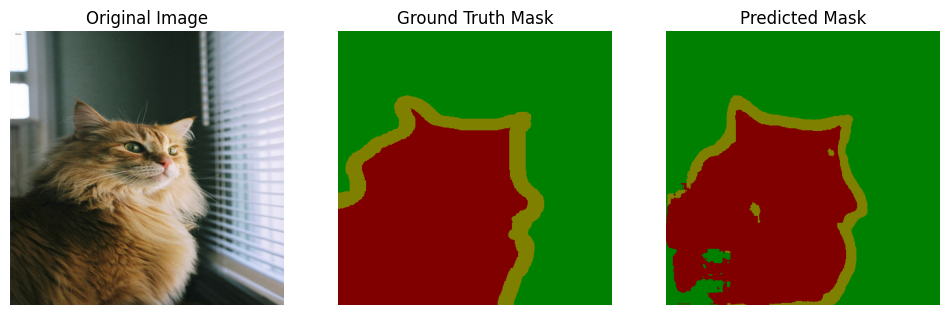

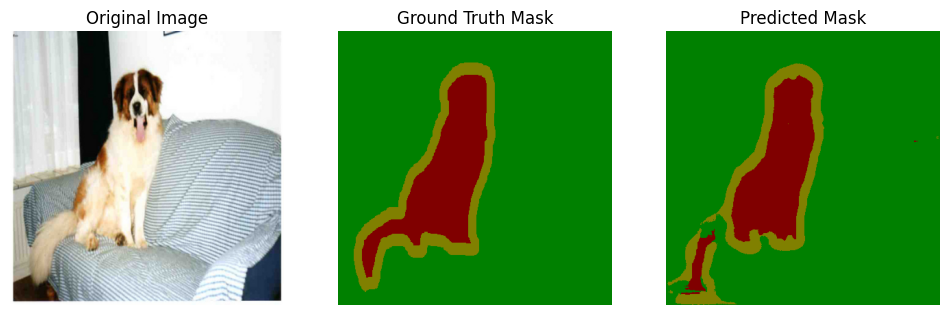

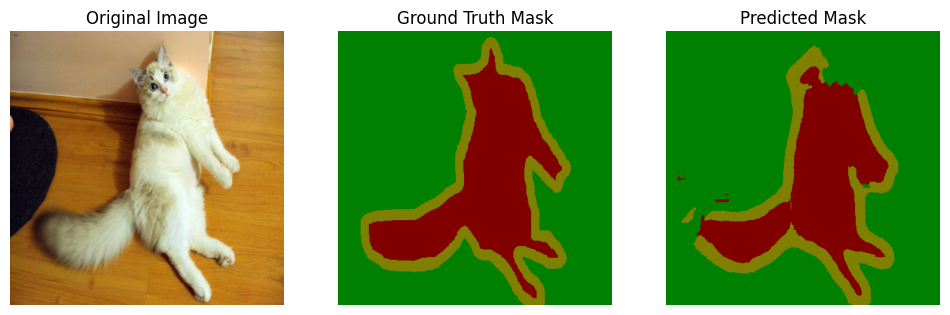

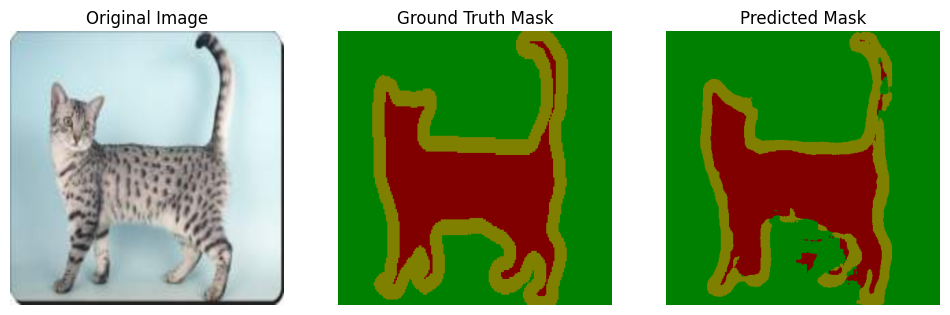

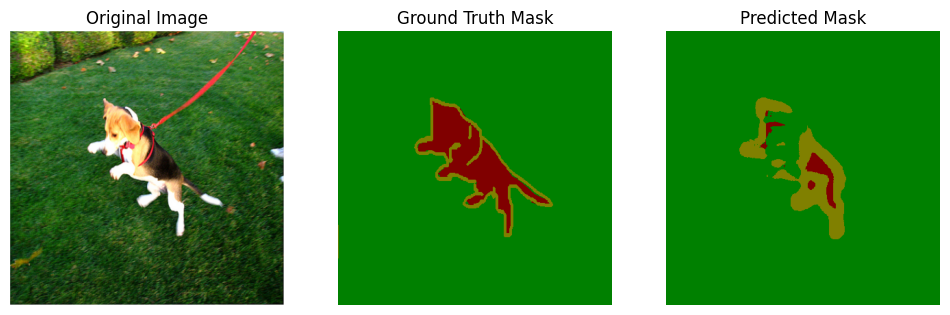

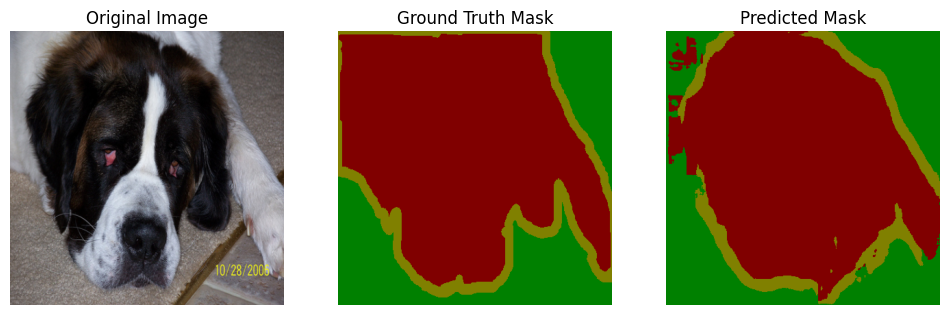

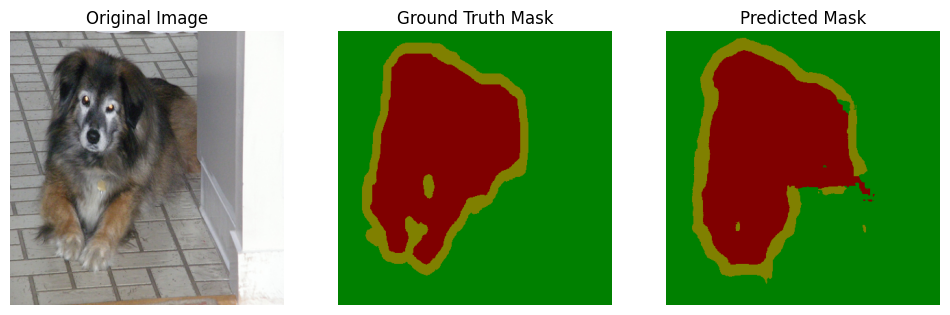

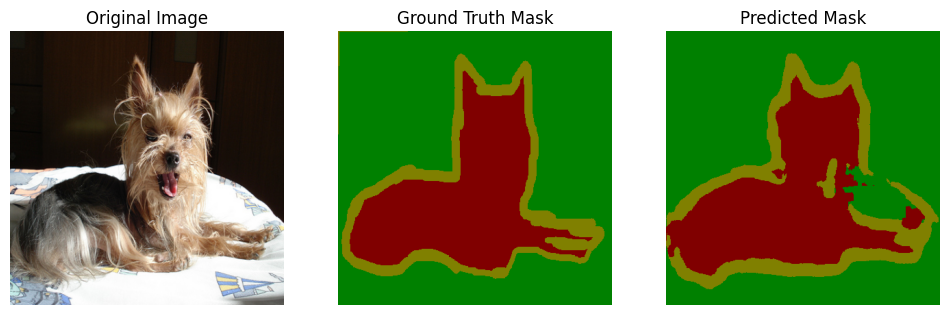

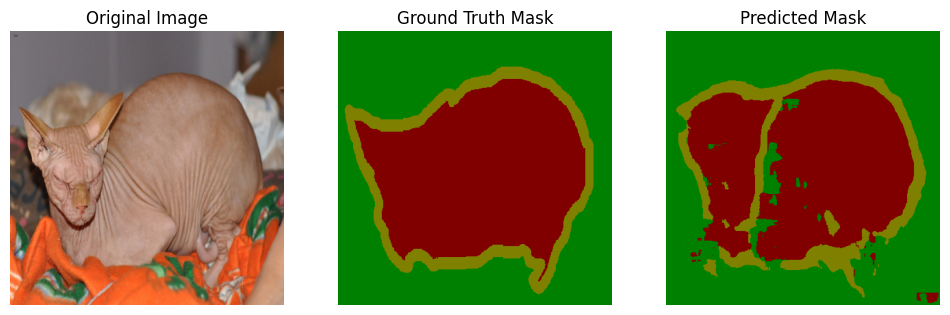

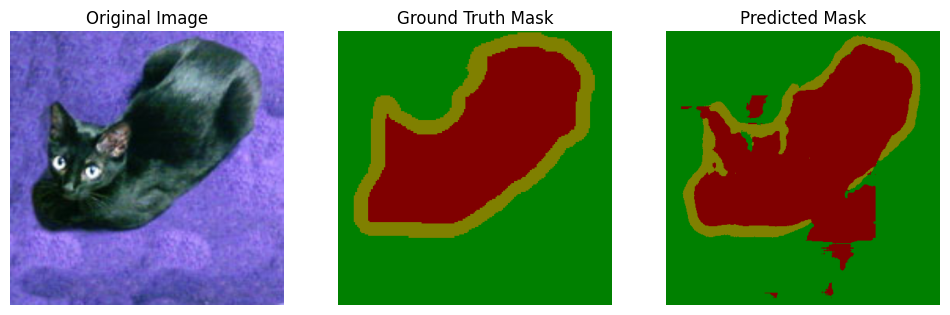

In [33]:
# Take a batch and visualize
model.eval()
with torch.no_grad():
    images, masks = next(iter(train_loader))
    images, masks = images.to(device), masks.to(device)
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

# Convert to numpy for plotting
images = images.cpu().permute(0, 2, 3, 1).numpy()
masks = masks.cpu().numpy()
preds = preds.cpu().numpy()

for i in range(len(images)):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(images[i])
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(decode_segmap(masks[i]))
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    axes[2].imshow(decode_segmap(preds[i]))
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    plt.show()

In [25]:
def preprocess_image(image_path):

    transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor()
    ])

    image = Image.open(image_path).convert('RGB')
    original_size = image.size  # (width, height)
    image_tensor = transform(image).unsqueeze(0).to(device)
    return image_tensor, original_size, image

In [26]:
def predict_custom_image(model, image_path):
    # preprocess the image
    input_tensor, original_size, original_image = preprocess_image(image_path)

    # Predict
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # (256, 256)

    # Resize prediction to original image dimensions
    pred_original_res = np.array(Image.fromarray(pred.astype(np.uint8)).resize(
        original_size,
        Image.NEAREST  # Preserve label IDs
    ))

    return pred_original_res, original_image

In [27]:
def visualize_prediction(original_image, prediction):
    # Convert prediction to color mask
    color_mask = decode_segmap(prediction)

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_image)
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(color_mask)
    ax[1].set_title("Predicted Mask")
    ax[1].axis('off')

    plt.show()

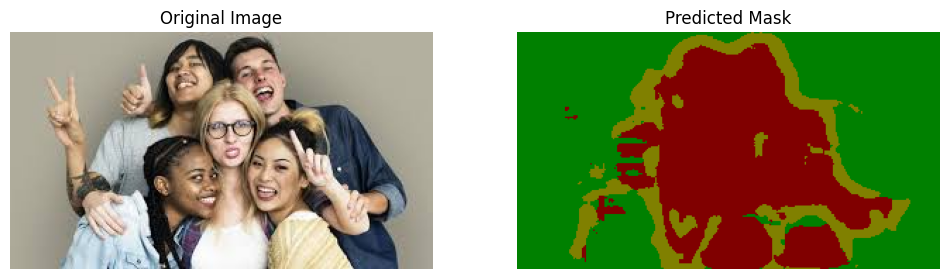

In [32]:
import torch
# from unet import UNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(n_classes=21).to(device)
model.load_state_dict(torch.load("best_unet.pth", map_location=device))
model.eval()

pred_mask, orig_img = predict_custom_image(model, "/content/people.jpeg")
visualize_prediction(orig_img, pred_mask)

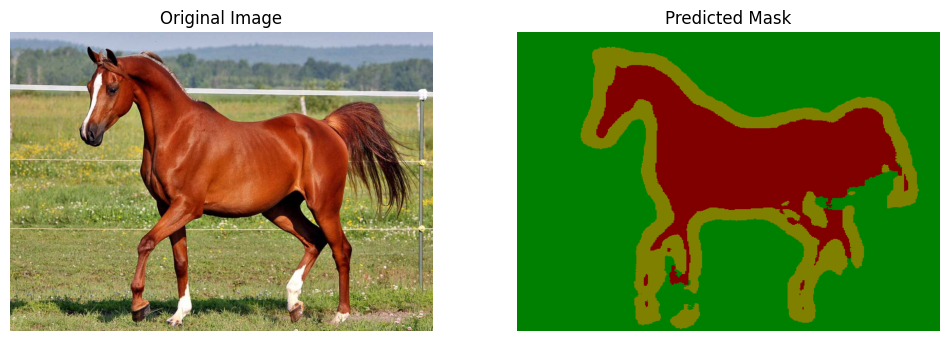

In [36]:
pred_mask, orig_img = predict_custom_image(model, "/content/horse.jpg")
visualize_prediction(orig_img, pred_mask)

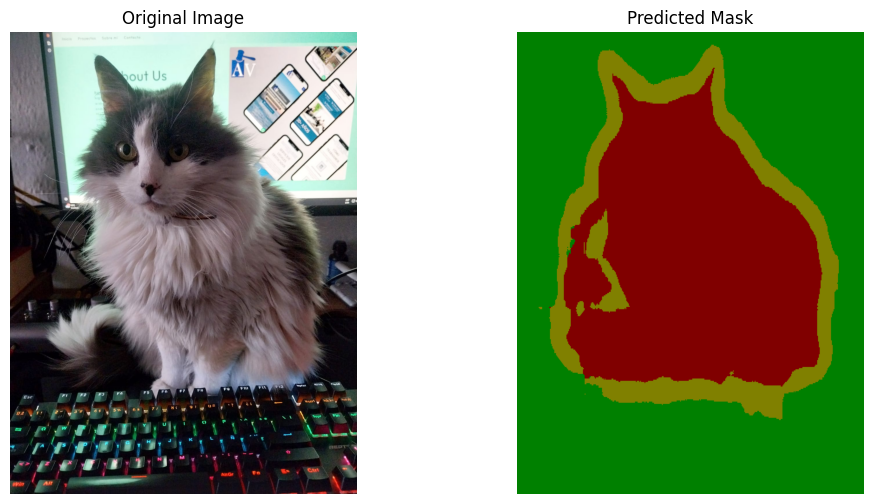

In [37]:
pred_mask, orig_img = predict_custom_image(model, "/content/enriqueta.jpeg")
visualize_prediction(orig_img, pred_mask)